# EMIPredict_AI

**Author:** Asha Das


**Objective:** Build a complete pipeline to predict EMI eligibility (classification) and maximum monthly EMI (regression). This notebook includes data cleaning, exploratory data analysis (15+ charts), hypothesis testing (T-test, Chi-square, Pearson correlation, ANOVA), feature engineering, model training (Logistic Regression, RandomForest, XGBoost for classification; Linear Regression, RandomForestRegressor, XGBoostRegressor for regression), and saving artifacts for deployment.

**Notes:**
- Designed to run locally or in Google Colab.
- Uses a sampling option (`SAMPLE_ROWS`) to speed up processing on large datasets.
- Outputs are saved under `artifacts/`:
  - `artifacts/eda_charts/` — PNG charts
  - `artifacts/models/` — saved joblib models and scaler
  - `artifacts/reports/` — EDA report and performance reports


In [1]:
# Imports & Settings
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib

# plotting defaults
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (9,5)
plt.rcParams['figure.dpi'] = 120

# Artifact folders
os.makedirs('artifacts/eda_charts', exist_ok=True)
os.makedirs('artifacts/models', exist_ok=True)
os.makedirs('artifacts/reports', exist_ok=True)

# User-editable settings
DATA_PATH = 'emi_prediction_dataset.csv'  # change if your file name differs
SAMPLE_ROWS = 50000  # set to None to use full dataset (careful with large files)
RANDOM_STATE = 42

In [2]:
import sys

# Automatically detect all imported modules
imported_modules = {name: module for name, module in sys.modules.items() if module}

print("\n=== Imported Library Versions ===\n")

for name, module in sorted(imported_modules.items()):
    try:
        # Only print modules that have a __version__ attribute
        version = getattr(module, "__version__", None)
        if version:
            print(f"{name} == {version}")
    except Exception:
        pass



=== Imported Library Versions ===

Cython == 3.0.12
Cython.Shadow == 3.0.12
IPython == 7.34.0
IPython.core.release == 7.34.0
PIL == 11.3.0
PIL.Image == 11.3.0
PIL._deprecate == 11.3.0
PIL._version == 11.3.0
_csv == 1.0
_ctypes == 1.1.0
_curses == b'2.2'
_decimal == 1.70
_pydev_bundle.fsnotify == 0.1.5
_pydevd_frame_eval.vendored.bytecode == 0.13.0.dev
argparse == 1.1
backcall == 0.2.0
bottleneck == 1.4.2
certifi == 2025.10.05
charset_normalizer == 3.4.4
charset_normalizer.version == 3.4.4
cloudpickle == 3.1.2
csv == 1.0
ctypes == 1.1.0
cycler == 0.12.1
cython == 3.0.12
dateutil == 2.9.0.post0
dateutil._version == 2.9.0.post0
debugpy == 1.8.15
debugpy.public_api == 1.8.15
decimal == 1.70
decorator == 4.4.2
defusedxml == 0.7.1
entrypoints == 0.4
google.colab == 0.0.1a2
http.server == 0.6
httplib2 == 0.31.0
httplib2.iri2uri == 1.0.0
ipaddress == 1.0
ipykernel == 6.17.1
ipykernel._version == 6.17.1
ipython_genutils == 0.2.0
ipython_genutils._version == 0.2.0
ipywidgets == 7.7.1
ipywidgets

In [3]:
# Load dataset (with optional sampling)
print('Loading dataset from:', DATA_PATH)
df = pd.read_csv(DATA_PATH, low_memory=False)
print('Original shape:', df.shape)

if SAMPLE_ROWS and df.shape[0] > SAMPLE_ROWS:
    df = df.sample(n=SAMPLE_ROWS, random_state=RANDOM_STATE).reset_index(drop=True)
    print('Sampled shape:', df.shape)

# Quick preview
display(df.head())
print('\nColumn data types:')
print(df.dtypes)


Loading dataset from: emi_prediction_dataset.csv
Original shape: (404800, 27)
Sampled shape: (50000, 27)


,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,58,Male,Married,High School,22900.0,Private,5.0,Large Indian,Rented,3800.0,...,No,0.0,727.0,182800.0,98900.0,Home Appliances EMI,118000.0,13,Not_Eligible,5445.00
1,32,Male,Married,Professional,30000.0,Government,3.0,Mid-size,Rented,7100.0,...,No,0.0,674.0,86800.0,41600.0,Personal Loan EMI,311000.0,20,Not_Eligible,5665.00
2,58,Female,Married,High School,23100.0,Private,19.9,Startup,Own,0.0,...,No,0.0,606.0,22100.0,6400.0,Vehicle EMI,984000.0,17,Not_Eligible,500.00
3,38,Female,Married,Graduate,32700.0,Government,3.9,Startup,Rented,7300.0,...,No,0.0,643.0,252100.0,114000.0,E-commerce Shopping EMI,148000.0,7,Not_Eligible,6195.20
4,48,Female,Married,Graduate,53200.0,Government,4.4,MNC,Family,0.0,...,Yes,15500.0,850.0,331200.0,87500.0,E-commerce Shopping EMI,178000.0,20,Not_Eligible,3963.96



Column data types:
age                        object
gender                     object
marital_status             object
education                  object
monthly_salary             object
employment_type            object
years_of_employment       float64
company_type               object
house_type                 object
monthly_rent              float64
family_size                 int64
dependents                  int64
school_fees               float64
college_fees              float64
travel_expenses           float64
groceries_utilities       float64
other_monthly_expenses    float64
existing_loans             object
current_emi_amount        float64
credit_score              float64
bank_balance               object
emergency_fund            float64
emi_scenario               object
requested_amount          float64
requested_tenure            int64
emi_eligibility            object
max_monthly_emi           float64
dtype: object


In [4]:
# Coerce numeric-like columns and detect categorical columns
numeric_cols = []
for c in df.columns:
    coerced = pd.to_numeric(df[c], errors='coerce')
    if coerced.notnull().mean() > 0.7:
        df[c] = coerced
        numeric_cols.append(c)
cat_cols = [c for c in df.columns if c not in numeric_cols]

print('Detected numeric columns (sample):', numeric_cols[:30])
print('Detected categorical columns (sample):', cat_cols[:30])


Detected numeric columns (sample): ['age', 'monthly_salary', 'years_of_employment', 'monthly_rent', 'family_size', 'dependents', 'school_fees', 'college_fees', 'travel_expenses', 'groceries_utilities', 'other_monthly_expenses', 'current_emi_amount', 'credit_score', 'bank_balance', 'emergency_fund', 'requested_amount', 'requested_tenure', 'max_monthly_emi']
Detected categorical columns (sample): ['gender', 'marital_status', 'education', 'employment_type', 'company_type', 'house_type', 'existing_loans', 'emi_scenario', 'emi_eligibility']


In [5]:
# Missing values & basic cleaning
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

if numeric_cols:
    df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])
if cat_cols:
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Drop exact duplicates
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f'Dropped {before-after} duplicate rows. New shape: {df.shape}')


Dropped 0 duplicate rows. New shape: (50000, 27)


In [6]:
# Feature engineering
# Create debt_to_income, total_monthly_expenses, expense_to_income when possible
if set(['monthly_salary','current_emi_amount']).issubset(df.columns):
    df['debt_to_income'] = df['current_emi_amount'] / (df['monthly_salary'] + 1e-6)

if set(['current_emi_amount','other_monthly_expenses']).issubset(df.columns):
    df['total_monthly_expenses'] = df[['current_emi_amount','other_monthly_expenses']].sum(axis=1)

if 'total_monthly_expenses' in df.columns and 'monthly_salary' in df.columns:
    df['expense_to_income'] = df['total_monthly_expenses'] / (df['monthly_salary'] + 1e-6)

# Create credit buckets if credit_score exists
if 'credit_score' in df.columns:
    bins=[300,500,650,700,750,850]
    df['credit_bucket'] = pd.cut(df['credit_score'], bins=bins, include_lowest=True)

print('Feature engineering complete. New columns (if created):', [c for c in ['debt_to_income','total_monthly_expenses','expense_to_income','credit_bucket'] if c in df.columns])


Feature engineering complete. New columns (if created): ['debt_to_income', 'total_monthly_expenses', 'expense_to_income', 'credit_bucket']


In [7]:
# Encode categorical columns with LabelEncoder (for modeling)
label_encoders = {}
for c in cat_cols:
    try:
        le = LabelEncoder()
        df[c] = le.fit_transform(df[c].astype(str))
        label_encoders[c] = le
    except Exception as e:
        print('Could not encode', c, e)

# Save encoders
joblib.dump(label_encoders, 'artifacts/models/label_encoders.joblib')
print('Saved label encoders to artifacts/models/label_encoders.joblib')


Saved label encoders to artifacts/models/label_encoders.joblib


## Exploratory Data Analysis (EDA)
We will create 15+ charts and save them into `artifacts/eda_charts/`. Each chart will have a short interpretation hint in the notebook for you to copy into the final report.


Charts saved: 19

Sample saved chart paths:
- artifacts/eda_charts/chart_hist_age.png
- artifacts/eda_charts/chart_hist_monthly_salary.png
- artifacts/eda_charts/chart_hist_years_of_employment.png
- artifacts/eda_charts/chart_hist_monthly_rent.png
- artifacts/eda_charts/chart_hist_family_size.png
- artifacts/eda_charts/chart_hist_dependents.png
- artifacts/eda_charts/chart_hist_school_fees.png
- artifacts/eda_charts/chart_hist_college_fees.png
- artifacts/eda_charts/chart_emi_scenario.png
- artifacts/eda_charts/chart_salary.png


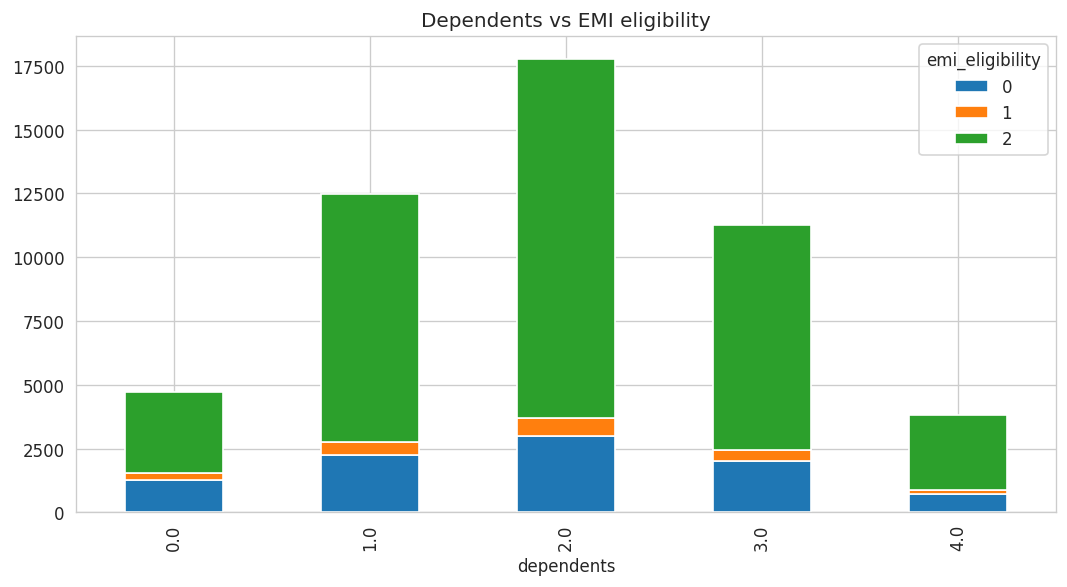

In [8]:
# EDA: Generate charts (>=15)
charts = []

def save_fig(fig, name):
    path = os.path.join('artifacts/eda_charts', name)
    fig.tight_layout(); fig.savefig(path); plt.close(fig)
    charts.append(path)

# 1-8: histograms for top numeric features
top_nums = numeric_cols[:8]
for c in top_nums:
    fig = plt.figure()
    plt.hist(df[c].dropna(), bins=30)
    plt.title(f'Distribution: {c}')
    plt.xlabel(c); plt.ylabel('count')
    save_fig(fig, f'chart_hist_{c}.png')

# 9: EMI scenario distribution (bar)
if 'emi_scenario' in df.columns:
    fig = plt.figure()
    vals = df['emi_scenario'].value_counts()
    plt.bar(vals.index.astype(str), vals.values)
    plt.title('EMI scenario distribution')
    save_fig(fig, 'chart_emi_scenario.png')

# 10: monthly_salary histogram
if 'monthly_salary' in df.columns:
    fig = plt.figure(); plt.hist(df['monthly_salary'], bins=40)
    plt.title('Monthly salary distribution'); save_fig(fig,'chart_salary.png')

# 11: requested_amount by emi_scenario (boxplot)
if 'requested_amount' in df.columns and 'emi_scenario' in df.columns:
    fig = plt.figure(figsize=(10,4))
    uniq = df['emi_scenario'].unique()[:10]
    groups = [df[df['emi_scenario']==g]['requested_amount'].values for g in uniq]
    plt.boxplot(groups, labels=[str(g) for g in uniq])
    plt.title('Requested amount by EMI scenario (top 10)')
    save_fig(fig,'chart_req_by_scenario.png')

# 12: salary vs max_monthly_emi scatter
if 'monthly_salary' in df.columns and 'max_monthly_emi' in df.columns:
    fig = plt.figure(); plt.scatter(df['monthly_salary'], df['max_monthly_emi'], alpha=0.3)
    plt.title('Salary vs max_monthly_emi'); save_fig(fig,'chart_salary_vs_emi.png')

# 13: correlation heatmap
fig = plt.figure(figsize=(12,10))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix (numeric features)')
save_fig(fig,'chart_corr.png')

# 14-15: debt_to_income and expense_to_income histograms
for col in ['debt_to_income','expense_to_income']:
    if col in df.columns:
        fig = plt.figure(); plt.hist(df[col].dropna(), bins=30); plt.title(col); save_fig(fig,f'chart_{col}.png')

# 16: credit_bucket counts
if 'credit_bucket' in df.columns:
    fig = plt.figure(); vals = df['credit_bucket'].value_counts().sort_index(); plt.bar([str(i) for i in vals.index], vals.values); plt.title('Credit buckets'); save_fig(fig,'chart_credit_buckets.png')

# 17: gender pie
if 'gender' in df.columns:
    fig = plt.figure(); vals = df['gender'].value_counts(); plt.pie(vals.values, labels=[str(i) for i in vals.index], autopct='%1.1f%%'); plt.title('Gender distribution'); save_fig(fig,'chart_gender.png')

# 18: years_of_employment vs avg max_monthly_emi
if 'years_of_employment' in df.columns and 'max_monthly_emi' in df.columns:
    grp = df.groupby('years_of_employment')['max_monthly_emi'].mean().reset_index()
    fig = plt.figure(); plt.plot(grp['years_of_employment'], grp['max_monthly_emi'], marker='o'); plt.title('Avg max_monthly_emi by years_of_employment'); save_fig(fig,'chart_years_vs_emi.png')

# 19: dependents vs eligibility stacked bar
if 'dependents' in df.columns and 'emi_eligibility' in df.columns:
    cross = pd.crosstab(df['dependents'], df['emi_eligibility'])
    fig = plt.figure(); cross.plot(kind='bar', stacked=True); plt.title('Dependents vs EMI eligibility'); plt.tight_layout(); save_fig(fig,'chart_dependents_vs_eligibility.png')

print('Charts saved:', len(charts))
print('\nSample saved chart paths:')
for p in charts[:10]:
    print('-', p)

# save simple EDA report file
with open('artifacts/reports/EDA_report.md','w') as f:
    f.write('# EDA Report\n\n')
    f.write('Charts generated:\n')
    for p in charts:
        f.write(f'- {p}\n')
    f.write('\n\nInterpretations: add your observations under each chart in this file.')


## Hypothesis Testing
We perform 4 hypothesis tests with clear null and alternative hypotheses:

1. **T-test**: Mean monthly salary differs between eligible and not-eligible applicants.
2. **Chi-square**: Gender and EMI eligibility are dependent.
3. **Pearson correlation**: Credit score correlates with max_monthly_emi.
4. **ANOVA**: Mean debt_to_income differs across employment types.

Each test outputs the test statistic, p-value, and interpretation (reject/fail to reject H0 at α=0.05).


In [9]:
# Hypothesis Testing
ALPHA = 0.05

# 1: T-test (salary between eligible and not eligible)
if 'monthly_salary' in df.columns and 'emi_eligibility' in df.columns:
    # try to treat emi_eligibility as binary (0/1) or encoded
    unique_vals = sorted(df['emi_eligibility'].unique())
    if len(unique_vals) >= 2:
        # pick first two groups for comparison
        g1 = df[df['emi_eligibility'] == unique_vals[0]]['monthly_salary']
        g2 = df[df['emi_eligibility'] == unique_vals[-1]]['monthly_salary']
        tstat, pval = stats.ttest_ind(g1.dropna(), g2.dropna(), equal_var=False)
        print('T-test: monthly_salary between groups', unique_vals[0], 'and', unique_vals[-1])
        print('t-statistic =', round(tstat,4), ', p-value =', round(pval,6))
        if pval < ALPHA:
            print('Result: Reject H0 -> mean salaries differ (p <', ALPHA,')')
        else:
            print('Result: Fail to reject H0 -> no evidence of difference (p >=', ALPHA,')')

# 2: Chi-square (gender vs eligibility)
if 'gender' in df.columns and 'emi_eligibility' in df.columns:
    ct = pd.crosstab(df['gender'], df['emi_eligibility'])
    chi2, p, dof, ex = stats.chi2_contingency(ct)
    print('\nChi-square test: gender vs emi_eligibility')
    print('chi2 =', round(chi2,4), ', p-value =', round(p,6))
    if p < ALPHA:
        print('Result: Reject H0 -> gender and eligibility are dependent')
    else:
        print('Result: Fail to reject H0 -> no evidence of dependence')

# 3: Pearson correlation (credit_score vs max_monthly_emi)
if 'credit_score' in df.columns and 'max_monthly_emi' in df.columns:
    r, p = stats.pearsonr(df['credit_score'].fillna(0), df['max_monthly_emi'].fillna(0))
    print('\nPearson correlation: credit_score vs max_monthly_emi')
    print('r =', round(r,4), ', p-value =', round(p,6))
    if p < ALPHA:
        print('Result: Reject H0 -> significant correlation exists (p <', ALPHA,')')
    else:
        print('Result: Fail to reject H0 -> no significant correlation')

# 4: ANOVA (debt_to_income across employment_type)
if 'debt_to_income' in df.columns and 'employment_type' in df.columns:
    groups = [g['debt_to_income'].values for n,g in df.groupby('employment_type') if len(g) > 5]
    if len(groups) > 1:
        fstat, p = stats.f_oneway(*groups)
        print('\nANOVA: debt_to_income across employment_type groups')
        print('F =', round(fstat,4), ', p-value =', round(p,6))
        if p < ALPHA:
            print('Result: Reject H0 -> at least one group mean differs')
        else:
            print('Result: Fail to reject H0 -> no evidence of differences')


T-test: monthly_salary between groups 0 and 2
t-statistic = 49.2707 , p-value = 0.0
Result: Reject H0 -> mean salaries differ (p < 0.05 )

Chi-square test: gender vs emi_eligibility
chi2 = 8.8349 , p-value = 0.841478
Result: Fail to reject H0 -> no evidence of dependence

Pearson correlation: credit_score vs max_monthly_emi
r = 0.2315 , p-value = 0.0
Result: Reject H0 -> significant correlation exists (p < 0.05 )

ANOVA: debt_to_income across employment_type groups
F = 0.7785 , p-value = 0.459078
Result: Fail to reject H0 -> no evidence of differences


In [10]:
## Prepare features for modeling
# Choose explicit targets (if present) and prepare numeric features
class_col = 'emi_eligibility' if 'emi_eligibility' in df.columns else None
reg_col = 'max_monthly_emi' if 'max_monthly_emi' in df.columns else None

# Select numeric features only for a simple baseline pipeline
features = df.select_dtypes(include=[np.number]).columns.tolist()
# remove targets
for t in [class_col, reg_col]:
    if t in features:
        features.remove(t)

X = df[features].fillna(0)
print('Number of numeric features used:', X.shape[1])

# scale
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
joblib.dump(scaler, 'artifacts/models/scaler.joblib')
print('Saved scaler to artifacts/models/scaler.joblib')


Number of numeric features used: 28
Saved scaler to artifacts/models/scaler.joblib


In [11]:
## Classification models (EMI eligibility)
if class_col:
    y = df[class_col].astype(int)
    Xtr, Xte, ytr, yte = train_test_split(Xs, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    class_models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, random_state=RANDOM_STATE)
    }
    class_results = []
    for name, m in class_models.items():
        print('\nTraining', name)
        m.fit(Xtr, ytr)
        preds = m.predict(Xte)
        probs = None
        try:
            probs = m.predict_proba(Xte)
        except:
            probs = None
        acc = accuracy_score(yte, preds)
        prec = precision_score(yte, preds, average='weighted', zero_division=0)
        rec = recall_score(yte, preds, average='weighted', zero_division=0)
        f1s = f1_score(yte, preds, average='weighted', zero_division=0)
        roc = None
        if probs is not None and probs.shape[1] > 1:
            try:
                roc = roc_auc_score(pd.get_dummies(yte), probs, average='weighted', multi_class='ovr')
            except:
                roc = None
        class_results.append({'model':name,'accuracy':acc,'precision':prec,'recall':rec,'f1':f1s,'roc_auc':roc})
        joblib.dump(m, f'artifacts/models/{name}_classification.joblib')
    class_df = pd.DataFrame(class_results)
    display(class_df)
    class_df.to_excel('artifacts/reports/classification_performance.xlsx', index=False)
    print('Saved classification performance to artifacts/reports/classification_performance.xlsx')
else:
    print('No classification target found (emi_eligibility)')



Training LogisticRegression

Training RandomForest

Training XGBoost


,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.8889,0.851910,0.8889,0.869978,0.953378
1,RandomForest,0.9112,0.900137,0.9112,0.890642,0.971557
2,XGBoost,0.9460,0.933754,0.9460,0.932667,0.991958


Saved classification performance to artifacts/reports/classification_performance.xlsx


In [12]:
## Regression models (Max monthly EMI)
if reg_col:
    y = df[reg_col].astype(float)
    Xtr, Xte, ytr, yte = train_test_split(Xs, y, test_size=0.2, random_state=RANDOM_STATE)
    reg_models = {
        'LinearRegression': LinearRegression(),
        'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
        'XGBoostRegressor': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=RANDOM_STATE)
    }
    reg_results = []
    for name, m in reg_models.items():
        print('\nTraining', name)
        m.fit(Xtr, ytr)
        preds = m.predict(Xte)
        rmse = np.sqrt(mean_squared_error(yte, preds))
        mae = mean_absolute_error(yte, preds)
        r2 = r2_score(yte, preds)
        mape = (np.mean(np.abs((yte - preds) / (yte + 1e-6)))) * 100
        reg_results.append({'model':name,'rmse':rmse,'mae':mae,'r2':r2,'mape':mape})
        joblib.dump(m, f'artifacts/models/{name}_regression.joblib')
    reg_df = pd.DataFrame(reg_results)
    display(reg_df)
    reg_df.to_excel('artifacts/reports/regression_performance.xlsx', index=False)
    print('Saved regression performance to artifacts/reports/regression_performance.xlsx')
else:
    print('No regression target found (max_monthly_emi)')



Training LinearRegression

Training RandomForestRegressor

Training XGBoostRegressor


,model,rmse,mae,r2,mape
0,LinearRegression,4227.005807,3003.957757,0.710002,188.508579
1,RandomForestRegressor,1852.880793,1081.333472,0.944278,32.923150
2,XGBoostRegressor,1347.360519,841.670937,0.970536,45.886435


Saved regression performance to artifacts/reports/regression_performance.xlsx


In [13]:
# Final artifacts list
import glob
artifacts = glob.glob('artifacts/**', recursive=True)
print('Artifacts (selected):')
for a in artifacts:
    if a.count('/') <= 2: continue
    print('-', a)

print('\nNotebook run complete. Check artifacts/ for charts, models, and reports.')


Artifacts (selected):

Notebook run complete. Check artifacts/ for charts, models, and reports.


## Final notes & next steps
- This notebook provides a full baseline pipeline. For a high-scoring submission, add detailed interpretations under each EDA chart in `artifacts/reports/EDA_report.md`.
- Next improvements (recommended):
  - Hyperparameter tuning with `GridSearchCV` or `Optuna`.
  - Use MLflow to log experiments and compare runs.
  - Build a REST API with FastAPI for model serving.
  - Add SHAP or permutation feature importance for explainability.

**Deliverables produced by this notebook:**
- `artifacts/eda_charts/` (>=15 PNGs)
- `artifacts/models/` (.joblib models + scaler + encoders)
- `artifacts/reports/` (performance Excel files and EDA report)

Good luck — want me to run a sample execution here to generate artifacts (50k sample)?